# TUTORIAL ON THE TOOLBOX `pLearningTools`

by Sebastian T. Glavind, June 2020

# EM for parameter learning from partially observed data

This notebook considers how to use the toolbox `pLearningTools` to learn the parameter distributions of a discrete Bayesian network model using the expectation-maximization (EM) algorithm, when the graph structure (DAG) and discretization policy for continuous variables are defined. The graph structure and discretization policy were found in a previous tutorial: *Dynamic discretization and structure learning from partially observed data*, which will be the basis for this tutorial.


## Prelude

In [27]:
library(bnlearn) # Package for learning bayesian networks (BNs)
library(gRain) # The inplementation makes used of the gRain package for inference in the EM algorithm
library(doParallel) # package for parallel computing
source("../MyToolboxes/pLearningTools.R") # load toolbox from source location

## Data and input

In this tutorial, we use the publicly available [sachs](https://www.bnlearn.com/book-crc/) data set.

### Raw data

In [28]:
DATA_org = read.table("../Discretize&sLearn/sachs.data.txt", header = T) # load continuous data set (data frame) from source location
DATA = DATA_org
nodes = names(DATA) # variable names

### Simulate missing data

In [29]:
set.seed(123)

m_DATA = as.matrix(DATA) # convert to matrix in order to perform matrix operations
m_n_D = length(m_DATA); # length of the unfolded array nrow*ncol
n_missing = floor(0.1*m_n_D) # no. of missing data
id_missing = arrayInd(sample(m_n_D, size = n_missing, replace = F), dim(m_DATA)) # indices of missing data
DATA[id_missing] = NA # convert input at these indices to NA

### Discrete data, discretization boundaries and BN model (from previous tutorial)

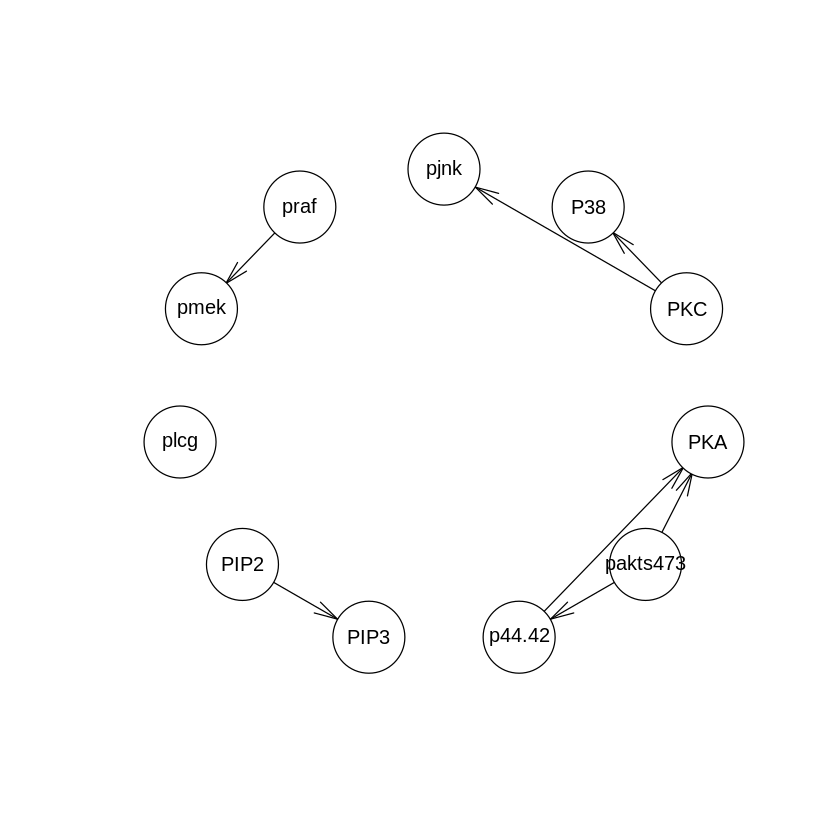

In [30]:
load("BNs_sLearn_partiallyObs.rda")

plot(RES1$BN)

In [31]:
summary(RES1$dDATA, maxsum = 20)

          praf              pmek              plcg              PIP2    
 (-Inf,40.7]:264   (-Inf,17.9]:190   (-Inf,13.2]:257   (-Inf,80.2]:494  
 (40.7,65.5]:254   (17.9,24.9]:212   (13.2,20.7]:255   (80.2,146] :159  
 (65.5, Inf]:254   (24.9,56]  :325   (20.7, Inf]:255   (146, Inf] :112  
 NA's       : 81   (56, Inf]  : 49   NA's       : 86   NA's       : 88  
                   NA's       : 77                                      
                                                                        
          PIP3             p44.42           pakts473           PKA     
 (-Inf,16.1]:257   (-Inf,9.61]:235   (-Inf,22.9]:259   (-Inf,134]: 25  
 (16.1,32.8]:248   (9.61,15.1]:157   (22.9,35.5]:259   (134,688] :565  
 (32.8, Inf]:250   (15.1,28.2]:264   (35.5, Inf]:254   (688, Inf]:182  
 NA's       : 98   (28.2, Inf]:112   NA's       : 81   NA's      : 81  
                   NA's       : 85                                     
                                                         

## Parameter learning

Having defined the graph structure and discretization, we can quantify the model parameters using Bayesian statistics with the Dirichlet equivalent uniform priors. In this regard we assume both global and local parameter independence, see e.g. Koller and Friedman (2009) for further details. Moreover, due to the missing data in this example, we will need to assume a missingness mechanism, and employ a learning algorithm that can deal with missing data. In this tutorial, we will assume that the data is missing at random and employ the expectation-maximization (EM) learning algorithm, see e.g. Koller and Friedman (2009) for further details.

***
D. Koller and N. Friedman, Probabilistic graphical models: principles and techniques. MIT Press, 2009.
***

### EM for maximum a-posteriori (MAP) parameter inference using `pLearningTools`

- BN: Graph structure (DAG) of class bn (bnlearn)
- dDATA: Discrete data set with missings
- n_iss: Imaginary sample size for Bayesian Dirichlet equivalent uniform prior, see e.g. Ueno (2010)
- no_cores: number of cores to use
- FITTED: bn.fit object, iff NULL (parm. initialized at random), iff RES1(FITTED) (initialized as parm. from sLearning)
- quiet: Print progress report, Iff = FALSE (related to discretize_all_oneIt)
- tol: Error tolerance for parameter convergence (all parameters)
- max_ite: Maximum number of EM iterations

***
M.  Ueno,  “Learning  networks  determined  by  the  ratio  of  prior  and  data,”  in Proceedings of 26th Conference on Uncertainty in Artificial Intelligence, 2010, pp. 1–8
***

In [32]:
scale_iss = 1 # current recommendation, see Ueno (2010)
quiet = T
no_cores <- detectCores() - 2
FITTED0=RES1$FITTED 
max_ite = length(nodes)*3
tol = 1e-7

#### EM algorithm

In [33]:
# This implementation should work on both Windows and Linux
RESem = EM_multicore(BN=RES1$BN, dDATA=RES1$dDATA, n_iss=scale_iss, no_cores=no_cores, FITTED=FITTED0, quiet=quiet,
                     tol=tol, max_ite=max_ite) # //*pLearningTools*//

#### Results

In [34]:
print(paste("Converged: ", RESem$n_ite < max_ite)) # access convergence
RESem$FITTED # EM-based bn.fit
# RESem$PC # corr. posterior counts

[1] "Converged:  TRUE"



  Bayesian network parameters

  Parameters of node praf (multinomial distribution)

Conditional probability table:
 praf
(-Inf,40.7] (40.7,65.5] (65.5, Inf] 
  0.3380747   0.3302778   0.3316475 

  Parameters of node pmek (multinomial distribution)

Conditional probability table:
 
             praf
pmek           (-Inf,40.7]  (40.7,65.5]  (65.5, Inf]
  (-Inf,17.9] 0.5650788542 0.1455482689 0.0169250782
  (17.9,24.9] 0.2892868632 0.4085917826 0.1251335425
  (24.9,56]   0.1452823478 0.4410827531 0.6736894957
  (56, Inf]   0.0003519348 0.0047771954 0.1842518836

  Parameters of node plcg (multinomial distribution)

Conditional probability table:
 plcg
(-Inf,13.2] (13.2,20.7] (20.7, Inf] 
  0.3350694   0.3324653   0.3324653 

  Parameters of node PIP2 (multinomial distribution)

Conditional probability table:
 PIP2
(-Inf,80.2]  (80.2,146]  (146, Inf] 
  0.6451490   0.2077177   0.1471332 

  Parameters of node PIP3 (multinomial distribution)

Conditional probability table:
 
            

### Endnotes

The fitted objects can now be used for inference in the fully specified BN model (graph and parameters), either using the FITTED-object for MAP inference, of using the PC-object to account for parameter uncertainties in the inferences. Using the PC-object of the last stage of EM is equivalent to employing a special case of variational inference, see e.g. Bishop (2006), Koller and Friedman (2009) and Gelman et al. (2013).

The details on how to conduct inference in Bayesian networks are covered in the tutorial on inference in Bayesian networks (*Inference with general bn.fit objects*), but two small examples are given below.

***
C. M. Bishop, Pattern recognition and machine learning. Springer, 2006.

D. Koller and N. Friedman, Probabilistic graphical models: principles and techniques.
MIT Press, 2009.

A. Gelman, J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, and D. B. Rubin,
Bayesian data analysis. CRC press, 2013.
***

#### Small example on MAP inference using the `gRain` package

In [35]:
junction = compile(as.grain(RESem$FITTED)) # gRain object - junction tree
summary(junction)

Independence network: Compiled: TRUE Propagated: FALSE 
 Nodes : chr [1:11] "praf" "pmek" "plcg" "PIP2" "PIP3" "p44.42" "pakts473" "PKA" ...
 Number of cliques:                 6 
 Maximal clique size:               3 
 Maximal state space in cliques:   36 


In [36]:
# Query: P(pjnk)
QGinf1m1 = querygrain(junction, nodes = c("pjnk"), type = "marginal")
QGinf1m1$pjnk

pjnk
(-Inf,14.9] (14.9,34.3] (34.3, Inf] 
  0.3402317   0.3284895   0.3312788

#### Small example on posterior inference accounting for parameters uncertainties

In [37]:
#  Query: P(pjnk = "(-Inf,14.6]")
N = 100
Ppjnk1 = c()
for (n in 1:N){
    CPTsamp_i = myDirichletSampler(PC = RESem$PC) # //*pLearningTools*//
    BNsamp_i = custom.fit(RES1$BN, dist = CPTsamp_i)
    junc_i = compile(as.grain(BNsamp_i))
    # P(pjnk)
    QGinf_i = querygrain(junc_i, nodes = c("pjnk"), type = "marginal")
    # P(pjnk = "(-Inf,14.6]")
    Ppjnk1 = c(Ppjnk1, QGinf_i$pjnk[1])
}

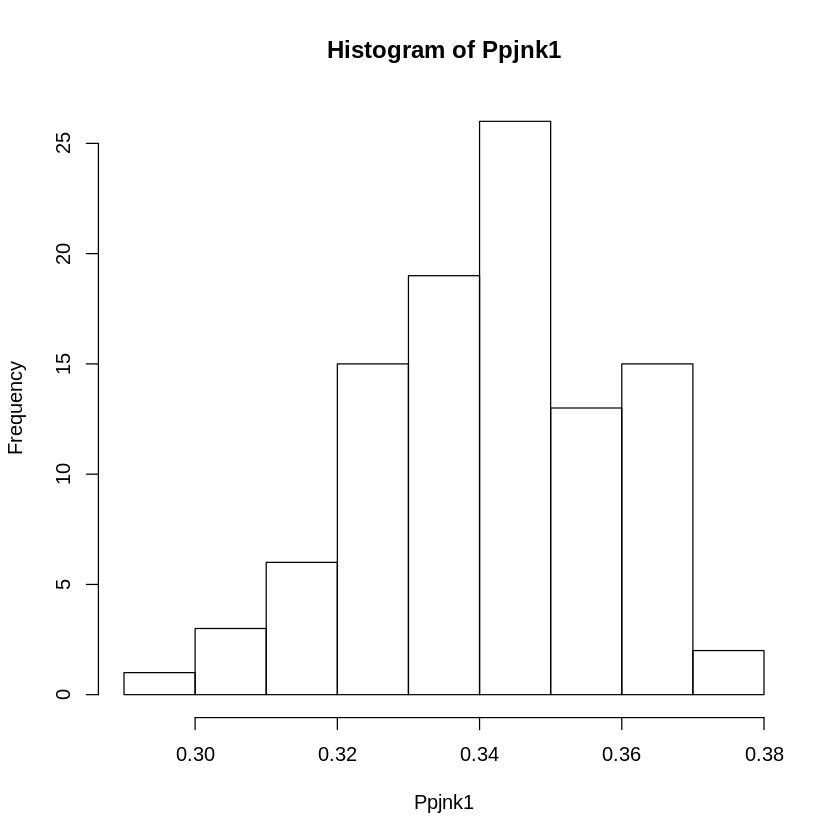

In [38]:
hist(Ppjnk1)

In [39]:
# save(RESem,file='BNs_pLearn_EM_partiallyObs.rda')